## Amazon Fine Food Reviews Analysis

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

##### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

###### Number of reviews: 568,454
###### Number of users: 256,059
###### Number of products: 74,258
###### Timespan: Oct 1999 - Oct 2012
###### Number of Attributes/Columns in data: 10

###### Attribute Information:

###### Id - Id of the row in the dataset
###### ProductId - unique identifier for the product
###### UserId - unqiue identifier for the user
###### ProfileName - name on the profile
###### HelpfulnessNumerator - number of users who found the review helpful
###### HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
###### Score - rating between 1 and 5
###### Time - timestamp for the review
###### Summary - brief summary of the review
###### Text - text of the review
###### Objective:
######  To plot the t-SNE Plot for the Bag Of Words Vector , TF-IDF vector , Avg W2V , TF-IDF W2V:


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import sqlite3
import string
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

# Making the connection to the database.sqlite
con = sqlite3.connect("C:\\Users\\Ashu\\Desktop\\AAIC\\IPython Notebooks\\AMAZON Fine Food Reviews\\amazon-fine-food-reviews\\database.sqlite")





In [160]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)



# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 'negative'
        else :
            return 'positive'
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [44]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
1,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
2,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
3,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


In [45]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

,Id,ProductId,UserId,ProfileName,Summary,Text,COUNT
0,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
1,217385,7310172101,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,2
2,369857,B000084DWM,A3TVZM3ZIXG8YW,christopher hayes,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",10
3,369801,B000084DWM,A36JDIN9RAAIEC,Jon,"Great product, but trust your vet not the hype","I have two cats, one 6 and one 2 years old. Bo...",2
4,410265,B000084EZ4,A2FGXWWR8ZU59C,Thomas Lawrence,"Cats love the food, but no pull-tab top, and d...","I appreciate being able to buy this larger, mo...",2
5,410304,B000084EZ4,A29JUMRL1US6YP,HTBK,Fantastic Food for Good Cat Health,The pet food industry can be one of the most i...,4


In [46]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...
1,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
2,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
3,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...
4,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...
5,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...


### Observation:

####    In above Analysis what we found is :
###### There are product's having the same productID's with same {'TEXT'} , {'Timestamp'} , {'UserID'}
###### There are products having the different productID's with same {'TEXT'} , {'Timestamp'} , {"helpfullnessNumerator"} , {"HelpfullnessNumerator"} 
##### We termed such type of the data in our data set as Redundant Data , so we perform various cleaning methods to remove them from
###### the Data Set.

In [47]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [48]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [49]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [50]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

positive    276668
negative     50140
Name: Score, dtype: int64

In [51]:
#Text_preprocessing of the Text data, let's see how the text looks like and howw much unwanted things are there in the data:
final['Text'].values[0:2] #return array of all columns values

array(['This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!',
       'Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.'],
      dtype=object)

# Observation:
#### We found many redundancy in the data set and some of the Books data which does not make any sense here.
##### We dropped the almost 160K records in data de duplication step.

# Text Preprocessing : 
### Removing Removing html tags
### Removing Punctuation charcaters
### Alphanumeric numbers 
### Length of words must be > 2  
### Uppercase to Lowercase
### Removing the stop words
### Using the Snowball Stemmer. 

In [52]:
#  I have the final pandas dataFrame let's print it and analyze the html tags in it:
final.shape

(326808, 10)

In [53]:
#Let's print out the html tags in the final dataframe:

import re
i = 0
for sentence in final['Text'].values:
    pattern = re.compile('<.*?>')
    if(len(re.findall(pattern , sentence))):
        print(sentence)
        print(i)
        break
        
i+=1    

I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.
0


In [54]:
#Now we have seen we have <br/> tags mostly in our data we will clean our data 

In [55]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')
print(sno.stem('tasty'))

{'most', "shouldn't", 'there', "won't", 'below', "couldn't", 'has', 'an', "aren't", "hasn't", 'your', 'under', 'yours', 'isn', 'ourselves', "didn't", 'y', 'are', 'shouldn', 'he', 'don', "you'd", 'for', 'having', 'their', 'now', 'i', 'yourselves', 'do', 'more', 'through', 'and', 'further', 'if', 'mustn', "don't", "haven't", "it's", 'both', 'such', "doesn't", 'my', "needn't", 'theirs', "should've", 'mightn', 'off', 'during', "hadn't", 'his', 'over', 'too', "that'll", 'wouldn', 'can', 'just', 'shan', 'will', 'did', 'hasn', 'ma', 'what', 'is', 'have', 'into', 'here', 'were', "isn't", 'as', 'with', 'above', "you've", 'you', 'we', "wasn't", 'because', 'her', 'who', 'in', 'ain', 'me', 'same', 'while', 'whom', 'against', 'own', 'at', 'been', 'being', 'wasn', 'out', 'which', 'once', 's', 'should', 'she', 'not', 'the', 'very', 'its', 'our', 'yourself', 'by', 'd', 'weren', 'that', 'couldn', "you're", 'few', "weren't", 'before', 'hadn', 'after', 'myself', 'only', 'other', 'was', 'had', 'doing', 'w

In [161]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [57]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [58]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape

(326808, 11)

In [67]:
#Storing the data to the database for the future use:
conn = sqlite3.connect('final_cleaned.sqlite')
c = conn.cursor()
final.to_sql('Reviews' , conn , if_exists='replace' , schema=None )
conn.close()

In [80]:
# Retreiving the data from the sqlite database and dropping the index column in the database table Reviews:

if os.path.isfile('final_cleaned.sqlite'):
    conn = sqlite3.connect('final_cleaned.sqlite')
    final_new = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please print the above cell")

#final_cleaned_data = final_new.drop('index',axis=0)
final_cleaned = final_new.drop(columns=['index'],inplace=False,axis=0)


In [87]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used
# used only roughly 7K points to further plot t-SNE plots which takes maximum amount of time.

final_subset = final.groupby('Score').apply(lambda x : x.sample(frac = 0.02))
print(final['Score'].value_counts())
print(final_subset['Score'].value_counts())
print('final_subset shape is :' , final_subset.shape)

positive    276668
negative     50140
Name: Score, dtype: int64
positive    5533
negative    1003
Name: Score, dtype: int64
final_subset shape is : (6536, 11)


#### BAG OF WORDS:

In [90]:
# Computing the Bag of words vector using CountVectorizer()

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
final_counts = cv.fit_transform(final_subset['CleanedText'].values)

print(type(final_counts))
print(final_counts.get_shape())
print(len(cv.get_feature_names()))

<class 'scipy.sparse.csr.csr_matrix'>
(6536, 10213)
10213


In [91]:
print(cv.get_feature_names()[1:100]) #uni-grams Bag of words

['aaah', 'aadult', 'aafco', 'abandon', 'abbi', 'abc', 'abdomin', 'abhor', 'abid', 'abil', 'abject', 'abl', 'ablsolut', 'abomin', 'abroad', 'abscess', 'absentmind', 'absolut', 'absolutley', 'absorb', 'absorpt', 'abstract', 'absurd', 'abund', 'abus', 'abv', 'abysm', 'acai', 'acana', 'accent', 'accept', 'access', 'accid', 'accident', 'accolad', 'accompani', 'accomplish', 'accord', 'account', 'accoutr', 'accross', 'acctual', 'accumul', 'accupuncturist', 'accur', 'accuraci', 'accus', 'accustom', 'acd', 'acerola', 'acesulfam', 'acet', 'ach', 'achiev', 'acid', 'acidmanganes', 'acknowledg', 'acn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'activia', 'actual', 'acv', 'ad', 'adagio', 'adam', 'adapt', 'add', 'addat', 'addendum', 'addict', 'addit', 'address', 'addtion', 'adequ', 'adher', 'adject', 'adjunct', 'adjust', 'admin', 'administ', 'administr', 'admir', 'admit', 'adobo', 'adopt', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'adventuresom', 'advers']


In [102]:
# Before plotting the t-SNE plot we will perform TruncatedSVD operation the Bag of words vector so as to perform 
# the dimensionality reduction:

# Create a TSVD with 3000 dimension :
tsvd = TruncatedSVD(n_components=2000)

# Conduct TSVD on sparse matrix final_counts:
final_counts = tsvd.fit(final_counts).transform(final_counts)

In [103]:
#Let's print the properties of the truncated sparse matrix :
print(final_counts.shape)
print(type(final_counts))
print(final_counts)

(6536, 2000)
<class 'numpy.ndarray'>
[[ 9.33331501e+00 -1.81716564e+00  1.12606662e+01 ...  2.89239043e-02
  -5.05116251e-02  7.16786523e-02]
 [ 5.32191327e-01 -1.28241741e-01 -9.48882340e-02 ... -2.46141755e-02
   2.44792169e-02 -2.31415569e-03]
 [ 1.02773337e+00 -1.38190300e-01 -6.62827226e-02 ... -5.93543916e-02
  -4.11801141e-02 -4.87263075e-03]
 ...
 [ 9.62514391e-01 -1.32309701e-01 -1.86438586e-02 ... -1.87535976e-03
  -2.63607248e-02 -2.27803055e-02]
 [ 1.61917966e+00 -2.39474612e-01 -4.93027326e-01 ...  1.18421301e-03
   3.08847146e-03 -1.64731524e-02]
 [ 1.25872449e+00 -3.96870270e-01 -5.61815332e-01 ... -7.57335801e-03
  -1.03351465e-01  5.14994198e-03]]


### Plotting the t-SNE for BAG OF WORDS:

In [104]:
#Scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
final_counts = scaler.fit_transform(final_counts)

(6536, 2)
(6536,)


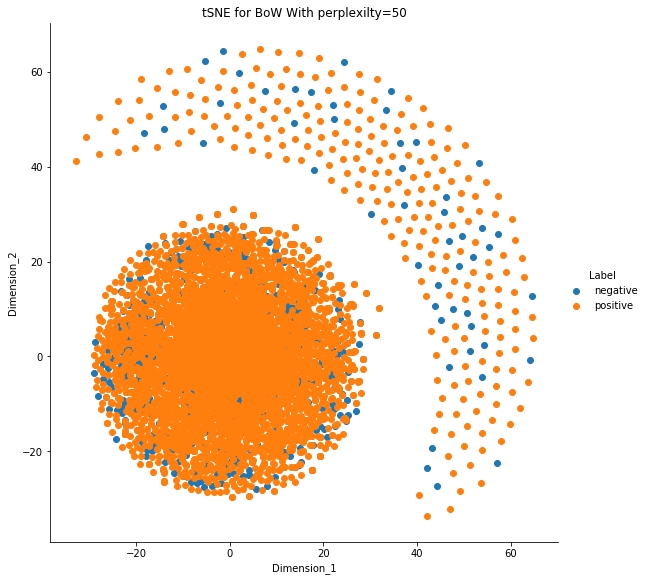

In [105]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2 , random_state=None , perplexity=50 , n_iter=750)

tsne_bow_data = model.fit_transform(final_counts)
label = final_subset['Score']
print(tsne_bow_data.shape)
print(label.shape)


tsne_bow_data=np.vstack((tsne_bow_data.T,label)).T
tsne_df=pd.DataFrame(data=tsne_bow_data,columns=("Dimension_1","Dimension_2","Label"))

#Plotting the 2D TSNE results:
sns.FacetGrid(tsne_df,hue='Label',size=8).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.title('tSNE for BoW With perplexilty=50')
plt.show()


#### Observation:
##### The data points are completely overlapped for both the classes of the data. It's hard to separate all the points with a hyperplane

In [139]:
#Let me calculate the Frequency Distribution of the words:

print('length of the positive words' ,len(all_positive_words))
print('length of the negative' ,len(all_negative_words))

freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)

print('Most Common positive words:' , freq_dist_positive.most_common(20))
print('Most Common neagtive words:' , freq_dist_negative.most_common(20))

length of the positive words 9299673
length of the negative 1814634
Most Common positive words: [(b'like', 117788), (b'tast', 110478), (b'good', 96771), (b'flavor', 95826), (b'love', 95821), (b'great', 91493), (b'use', 83676), (b'one', 80592), (b'product', 76477), (b'tea', 72948), (b'tri', 72059), (b'coffe', 70127), (b'make', 60772), (b'get', 60383), (b'food', 52072), (b'buy', 46893), (b'would', 46252), (b'time', 45948), (b'realli', 44598), (b'price', 43221)]
Most Common neagtive words: [(b'tast', 29483), (b'like', 27007), (b'product', 22509), (b'flavor', 16788), (b'one', 16695), (b'would', 14642), (b'tri', 14467), (b'coffe', 12578), (b'good', 12384), (b'use', 11966), (b'buy', 11452), (b'get', 11267), (b'order', 10722), (b'tea', 10091), (b'food', 9477), (b'even', 8953), (b'box', 8933), (b'bag', 8212), (b'amazon', 8037), (b'time', 7887)]


# TFIDF VECTOR COMPUTATION:

In [141]:
#Uni Gram gram Tf-IDF Vector
tfidf_vector = TfidfVectorizer(ngram_range=(1,1) , min_df=5 )
tfidf_count_values = tfidf_vector.fit_transform(final_subset['CleanedText'].values)
print(type(tfidf_count_values))
print(tfidf_count_values.get_shape())
print(tfidf_count_values.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(6536, 3135)
3135


In [142]:
# Before plotting the t-SNE plot we will perform TruncatedSVD operation for the TFIDF vector so as to perform 
# the dimensionality reduction:

# Create a TSVD with 1000 dimension :
tsvd = TruncatedSVD(n_components=2000)

# Conduct TSVD on sparse matrix final_counts:
tfidf_count_values = tsvd.fit(tfidf_count_values).transform(tfidf_count_values)
type(tfidf_count_values)

numpy.ndarray

In [143]:
#Scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
tfidf_standard = scaler.fit_transform(tfidf_count_values)

## t-SNE Plotting of the Uni-gram TFIDF Vector:

(6536, 2)
(6536,)


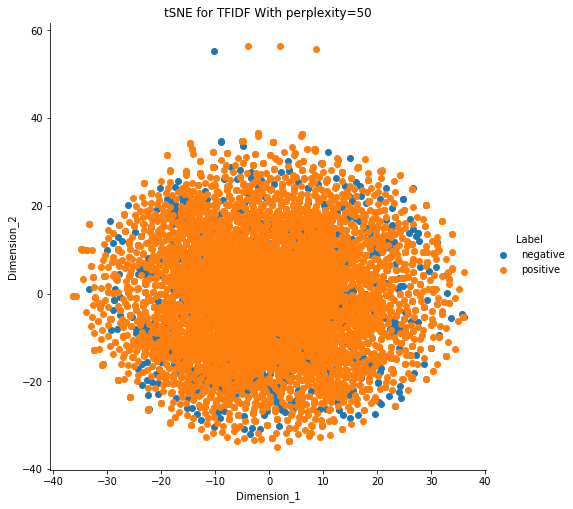

In [144]:
#tSNE plot:-

model = TSNE(n_components=2 , random_state=None , perplexity=50 , n_iter=750)

tsne_data = model.fit_transform(tfidf_standard)
label = final_subset['Score']
print(tsne_data.shape)
print(label.shape)


tsne_data=np.vstack((tsne_data.T,label)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","Label"))

#Plotting the 2D TSNE results:
sns.FacetGrid(tsne_df,hue='Label',size=7).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.title('tSNE for TFIDF With perplexity=50')
plt.show()

#### Observation:
#### The data points are completely overlapped for both the classes of the data. It's hard to separate all the points with a hyperplane¶

In [145]:
#Lets get the vaues of the features of some indexes in the sparse tf_idf vector:

features = tfidf_vector.get_feature_names()
print(features[500:580])


['chunki', 'church', 'cider', 'cinnamon', 'citi', 'citric', 'citrus', 'claim', 'clam', 'class', 'classic', 'clean', 'cleaner', 'clear', 'clearanc', 'click', 'client', 'clock', 'clog', 'close', 'closer', 'closest', 'cloth', 'clove', 'cloy', 'club', 'clue', 'clump', 'cluster', 'clutter', 'coars', 'coast', 'coat', 'coca', 'cocktail', 'coco', 'cocoa', 'coconut', 'code', 'coff', 'coffe', 'coin', 'coke', 'cola', 'colada', 'cold', 'collect', 'colleg', 'colombian', 'color', 'columbian', 'com', 'combin', 'combo', 'come', 'comfort', 'comment', 'commerci', 'commit', 'common', 'communiti', 'compani', 'companion', 'compar', 'comparison', 'compens', 'competit', 'competitor', 'complain', 'complaint', 'complement', 'complet', 'complex', 'compliment', 'compost', 'compromis', 'comput', 'con', 'concentr', 'concept']


In [146]:
# Now we will Train our own model using Word2vec:
list_of_sentence=[]
for sent in final_subset['CleanedText'].values:
    list_of_sentence.append(sent.split())
print(final_subset['CleanedText'].values[0])
print(list_of_sentence[0])


assum medium product label suppos indic medium roast certain roast much like starbuck noth person prefer worthi refer point other coffe hate coffe espresso brew starbuck perfect disturb tast bit less like coffe stuff left fire pit camp site fire burnt realli kind bean seed pine cone pulpi wood roast appropri unrecogniz state would produc similar charcoal flavor touch lighter fluid perhap indic toward coffe say stuff go reprehens starbuck recip care roast pitch black flavor essenti unrecogniz coffe still hold coffe bean shape prefer medium espresso medium light brew coffe like smell flavor bean way coffe actual smell roast roast time time like coffe flavor treat tri sometim nutti rich warm acrid bitter like type tri illi espresso point refer great coffe tast like tuppenc worth product review espresso indistinguish starbuck roast take approach roast espresso bean tast might cheaper might expens one extrem dark brew fact could good bad depend prefer coffe
['assum', 'medium', 'product', 'l

In [147]:
# Creating the gensim model
import gensim
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=50 , workers=4)

In [148]:
#Let's get our trained model vocabulary:

vocab_list = list(model.wv.vocab)
print("Words that exist more than 5 times are :" , len(vocab_list))
print(vocab_list[0:60])

Words that exist more than 5 times are : 3405
['assum', 'medium', 'product', 'label', 'suppos', 'indic', 'roast', 'certain', 'much', 'like', 'starbuck', 'noth', 'person', 'prefer', 'worthi', 'refer', 'point', 'other', 'coffe', 'hate', 'espresso', 'brew', 'perfect', 'disturb', 'tast', 'bit', 'less', 'stuff', 'left', 'fire', 'pit', 'camp', 'site', 'burnt', 'realli', 'kind', 'bean', 'seed', 'pine', 'cone', 'wood', 'appropri', 'state', 'would', 'produc', 'similar', 'flavor', 'touch', 'lighter', 'fluid', 'perhap', 'toward', 'say', 'go', 'recip', 'care', 'black', 'essenti', 'still', 'hold']


# Avg W2V 

In [149]:
#Computing the Average word2vec:
sent_vect= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence):
    sen_vec = np.zeros(50) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect.append(sen_vec)

print(len(sent_vect))

print(len(sent_vect[0]))
        

100%|█████████████████████████████████████| 6536/6536 [00:11<00:00, 570.89it/s]


6536
50


In [150]:
sent_vect = np.array(sent_vect)
type(sent_vect)

numpy.ndarray

## t-SNE Plot for the Avg W2V vector:

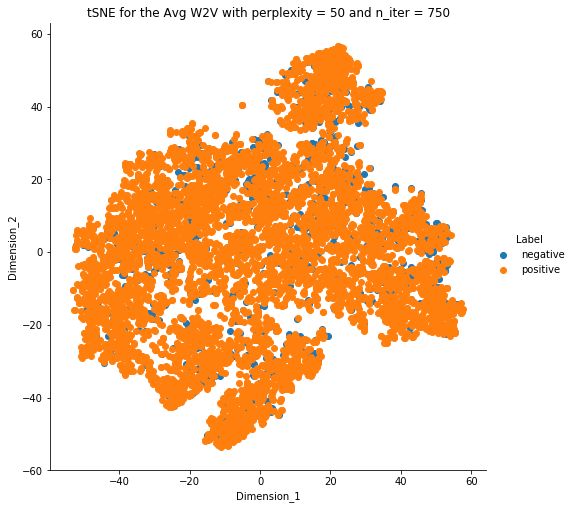

In [153]:
# Let's plot the t-SNE plot the average word to vector :
# here we have computed all the sentences as the vector using the avgw2v algorithm

model = TSNE(n_components=2 , random_state=None , perplexity = 50 , n_iter =750)

#Let's fit the standardised data into the tsne model:

scaled_vectors = StandardScaler().fit_transform(sent_vect)

#Since all the vectors are densed so there is no need of TruncatedSVD

tsne_data = model.fit_transform(scaled_vectors)
label = final_subset["Score"]
tsne_data = np.vstack((tsne_data.T , label)).T

tsne_df = pd.DataFrame(data=tsne_data , columns=['Dimension_1' , 'Dimension_2', 'Label' ])

#Plotting the tsne data of Avg W2V in 2D:

sns.FacetGrid(tsne_df , hue='Label' , size=7).map(plt.scatter , 'Dimension_1' , 'Dimension_2').add_legend()
plt.title("tSNE for the Avg W2V with perplexity = 50 and n_iter = 750")
plt.show()


### Observation :
#### As compared to the BoW and TFIDF the above plot is having large vectors for the positve point. Even it is hard to visualise the 
#### the less amount of the data.

#### The two class labels point are hard to separate via a hyperplane.

### TFIDF-AvgW2V :

In [154]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(final_subset['CleanedText'].values)
# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [156]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=50 , workers=4)

In [157]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors))

print(len(tfidf_sent_vectors[0]))

100%|█████████████████████████████████████| 6536/6536 [00:14<00:00, 458.23it/s]



 6536
50


In [158]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
type(tfidf_sent_vectors)

numpy.ndarray

## tSNE Plotting for the TFIDF - W2v :

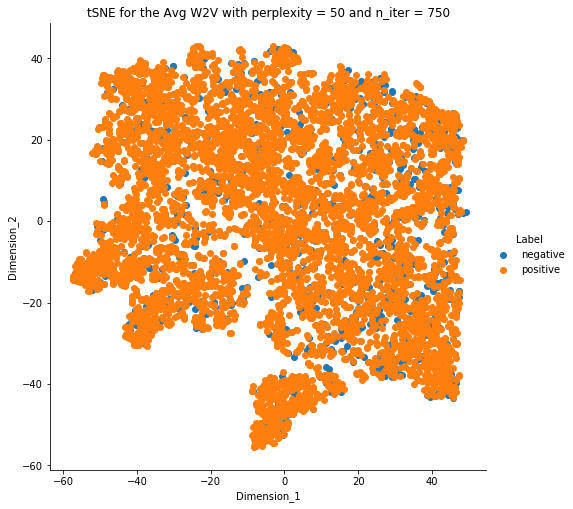

In [159]:
# Let's plot the t-SNE plot the average word to vector :
# here we have computed all the sentences as the vector using the avgw2v algorithm

model = TSNE(n_components=2 , random_state=None , perplexity = 50 , n_iter =750)

#Let's fit the standardised data into the tsne model:

scaled_vectors = StandardScaler().fit_transform(tfidf_sent_vectors)

#Since all the vectors are densed so there is no need of TruncatedSVD

tsne_data = model.fit_transform(scaled_vectors)
label = final_subset["Score"]
tsne_data = np.vstack((tsne_data.T , label)).T

tsne_df = pd.DataFrame(data=tsne_data , columns=['Dimension_1' , 'Dimension_2', 'Label' ])

#Plotting the tsne data of Avg W2V in 2D:

sns.FacetGrid(tsne_df , hue='Label' , size=7).map(plt.scatter , 'Dimension_1' , 'Dimension_2').add_legend()
plt.title("tSNE for the Avg W2V with perplexity = 50 and n_iter = 750")
plt.show()


### Observation:
#### The t-SNE plot we get here is quite having visualisation as that of Avg W2V.
####  Here also it's too hard to separate these points via a hyperplane.

## Summary:
##### AS none of TSNE representation gives a well separated both positive and negative reviews.
##### We can not simply draw a plane to separate negative and postive reviews. Just  by looking at the plot we can't determine the differences.
##### We will have to find some alternative method to solve  this problem of  how we can separate positive and negative reviews.